### 1. INTRODUÇÃO

Nosso trabalho aqui consiste em criar um modelo para prever preços de casas, a partir de suas caracteristicas.
Embora o modelo esteja sendo aplicado para Boston, é possivel utilizar as mesmas premissas, ou a mesma estrutura, para criar um que seja aplicável ao Brasil (ou qualquer região de interesse).

### 2. CARREGA BIBLIOTECAS

In [1]:
# para tratar os dados

import pandas as pd
import numpy as np

# preprocessamento
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer # pipeline com colunas de tipos diferentes
from sklearn.impute import SimpleImputer # missing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler # escala das features
from category_encoders import TargetEncoder, OneHotEncoder # tratamento de categoricas
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_regression # selecao de features

# Modelagem
import lightgbm as lgb

# configuracoes gerais
import warnings

warnings.filterwarnings('ignore')

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

housing = pd.read_csv('housing.csv', header = None, delimiter=r"\s+", names = column_names)
housing.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


<IPython.core.display.Javascript object>

In [3]:
housing.shape

(506, 14)

<IPython.core.display.Javascript object>

In [4]:
housing.isna().mean() # mean() para ver a taxa de missing

CRIM       0.0
ZN         0.0
INDUS      0.0
CHAS       0.0
NOX        0.0
RM         0.0
AGE        0.0
DIS        0.0
RAD        0.0
TAX        0.0
PTRATIO    0.0
B          0.0
LSTAT      0.0
MEDV       0.0
dtype: float64

<IPython.core.display.Javascript object>

Digamos que a gente queira excluir linhas com mais de 30% de missing. O que fazer?
```python
housing_v2 = (housing.isna().mean() <= 0.3).index
```

### 3. Análise Exploratória

Novamente, não vamos fazer análise exploratória. Vamos tentar olhar mais sob a perspectiva de um processo automatizado onde não é possivel ficar olhando as features uma a uma. Além disso, nem sempre a gente consegue confiar 100% na EDA. Então é importante conhecer técnicas de feature selection e não achar que a EDA é a resposta final.

### 4.Modelo Predivitivo de Preço

Há diversas formas de selecionar features. Podemos olhar pela perspectiva univariada, de olhar features que possuem baixa variancia, que sao constantes, dentre outras formas. Ou, minha preferida, de uma perpectiva de relacao entre as features e o target. Alias, em tempo, tambem poderiamos olhar a relacao das features entre si, como, por exemplo, excluindo as que possuem alta correlacao - pois seriam redundantes - ou utilizando tecnicas como PCA - cuja ideia seria ate parecida com a da corralecao.

Algumas tecnicas que eu gosto e que com certeza olharemos no futuro, mas que voce pode ja ir lendo se quiser:
- RFE (Recursive Feature Elimination)
- SelectKBest
- SelectFromModel

In [5]:
housing.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


<IPython.core.display.Javascript object>

Como tudo é numérico, vou criar uma feature categórica, para mostrar uns tratamentos que podem ser úteis no futuro:


In [6]:
housing['CHAS'] = housing['CHAS'].map({1:'Yes', 0:'No'})
housing['CHAS'].value_counts()

No     471
Yes     35
Name: CHAS, dtype: int64

<IPython.core.display.Javascript object>

E se a gente tivesse que automatizar a criação da lista de features numéricas e categóricas?

In [7]:
categorical_columns = housing.select_dtypes(exclude='number').columns.to_list()
numerical_columns = housing.select_dtypes(include='number').columns.to_list()

<IPython.core.display.Javascript object>

In [8]:
housing[categorical_columns].head()

,CHAS
0,No
1,No
2,No
3,No
4,No


<IPython.core.display.Javascript object>

In [9]:
housing[numerical_columns].head()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


<IPython.core.display.Javascript object>

In [10]:
numerical_columns = [feature for feature in numerical_columns if feature != 'MEDV']
target = 'MEDV'

<IPython.core.display.Javascript object>

In [11]:
X = housing[numerical_columns + categorical_columns]
y = housing[target]

<IPython.core.display.Javascript object>

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

print(f"X_train shape:{X_train.shape}")
print(f"X_test shape:{X_test.shape}")
print(f"y_train shape:{y_train.shape}")
print(f"y_test shape:{y_test.shape}")

X_train shape:(354, 13)
X_test shape:(152, 13)
y_train shape:(354,)
y_test shape:(152,)


<IPython.core.display.Javascript object>

In [13]:
import lightgbm as lgb
#from lightgbm import LGBMRegressor

lgb_model = lgb.LGBMRegressor()

numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder())])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_columns),
    ('cat', categorical_transformer, categorical_columns)]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_regression, k=10)),
    ('model', lgb_model),
])

# Treina o modelo
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CRIM', 'ZN', 'INDUS', 'NOX',
                                                   'RM', 'AGE', 'DIS', 'RAD',
                                                   'TAX', 'PTRATIO', 'B',
                                                   'LSTAT']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['CHAS'])])),
                ('feature_selection',
                 SelectKBest(score_func=<function f_regression at 0x7fa38efa1990>)),
                ('model', LGBMRegressor())])

<IPython.core.display.Javascript object>

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")

Mean Squared Error (MSE): 11.7525
Root Mean Squared Error (RMSE): 3.4282
Mean Absolute Error (MAE): 2.3137
R-squared (R2): 0.8423


<IPython.core.display.Javascript object>

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("ggplot")

<IPython.core.display.Javascript object>

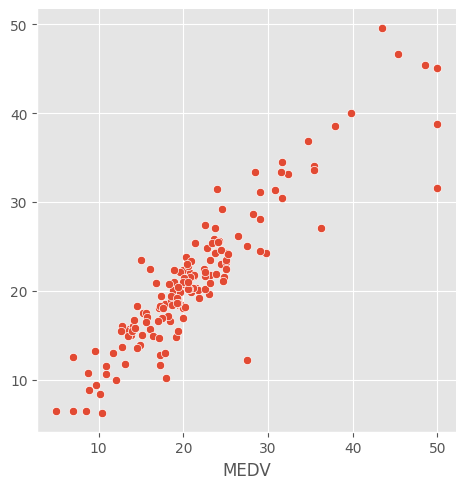

<IPython.core.display.Javascript object>

In [20]:
_ = sns.relplot(x=y_test, y=y_pred)
_ = plt.show()

### Discretização

In [21]:
housing.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,No,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,No,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,No,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,No,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,No,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


<IPython.core.display.Javascript object>

In [24]:
from feature_engine.discretisation import(
    EqualWidthDiscretiser,
    EqualFrequencyDiscretiser,
    DecisionTreeDiscretiser
)

<IPython.core.display.Javascript object>

In [33]:
ewd = EqualWidthDiscretiser()
ewd.fit(housing[['AGE']])

EqualWidthDiscretiser()

<IPython.core.display.Javascript object>

In [34]:
housing['AGE_EWD'] = ewd.transform(housing[['AGE']])
housing.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,AGE_EWD
0,0.00632,18.0,2.31,No,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0,6
1,0.02731,0.0,7.07,No,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6,7
2,0.02729,0.0,7.07,No,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7,5
3,0.03237,0.0,2.18,No,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4,4
4,0.06905,0.0,2.18,No,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2,5


<IPython.core.display.Javascript object>

In [35]:
housing.groupby('AGE_EWD').agg({'AGE':['mean', 'mean', 'min', 'max', 'size']})

AGE                             
              mean       mean   min    max size
AGE_EWD                                        
0         7.442857   7.442857   2.9   10.0   14
1        18.587097  18.587097  13.0   22.3   31
2        28.675862  28.675862  22.9   32.0   29
3        36.326190  36.326190  32.1   41.5   42
4        45.978125  45.978125  41.9   51.0   32
5        55.852632  55.852632  51.8   61.1   38
6        66.317949  66.317949  61.4   70.6   39
7        75.857143  75.857143  71.0   80.3   42
8        85.795775  85.795775  80.8   90.0   71
9        96.450000  96.450000  90.3  100.0  168

<IPython.core.display.Javascript object>

In [36]:
efd = EqualFrequencyDiscretiser()
efd.fit(housing[['AGE']])
housing[['AGE_EFD']]=efd.transform(housing[['AGE']])

housing.groupby('AGE_EFD').agg({'AGE':['mean', 'mean', 'min', 'max', 'size']})

AGE                             
              mean       mean   min    max size
AGE_EFD                                        
0        16.213725  16.213725   2.9   26.3   51
1        32.443137  32.443137  27.6   37.8   51
2        44.716000  44.716000  38.1   52.3   50
3        58.652941  58.652941  52.5   65.4   51
4        71.800000  71.800000  66.1   77.3   50
5        82.254902  82.254902  77.7   85.9   51
6        89.241176  89.241176  86.1   91.8   51
7        93.982000  93.982000  91.9   95.6   50
8        97.354717  97.354717  95.7   98.8   53
9        99.897917  99.897917  98.9  100.0   48

<IPython.core.display.Javascript object>

In [39]:
tree = DecisionTreeDiscretiser()
tree.fit(housing[['AGE']], housing[['MEDV']])
housing[['AGE_TREE']]=tree.transform(housing[['AGE']])

housing.groupby('AGE_TREE').agg({'AGE':['mean', 'mean', 'min', 'max', 'size']})

AGE                             
                mean       mean   min    max size
AGE_TREE                                         
17.483673  97.182993  97.182993  92.4  100.0  147
21.681579  85.337719  85.337719  76.5   92.2  114
24.730345  57.090345  57.090345  37.3   76.0  145
27.739000  24.064000  24.064000   2.9   37.2  100

<IPython.core.display.Javascript object>